# 5 Segment Dataset Model Building on All Joints
Here the demo model for all fingers closing at once is built on all joints. This model will be built with the 1.4M parameter large model with dropout

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('jackson_all_fingers_5_joined.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [5]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571870e+09,0.005692,1.571870e+09,78.0,191.0,489.0,49.0,32.0,28.0,26.0,30.0,32.740116,-24.541840,34.267227,11.553036,-45.455826,37.332489,-27.890228,-38.843796,9.545334,-48.374039,-32.275177,-15.826324,-64.700027,-28.397400,-31.309944,-33.500755,5.439697,-6.636353,-49.370407,18.675888,-43.101730,-54.321281,16.026352,-66.003845,-55.189941,9.038986,-81.112251,-15.335472,15.945602,-11.712173,-32.046516,34.042282,-51.768417,-39.209435,30.390823,-78.320190,-41.772079,21.434891,-94.110550,6.128254,21.192429,-14.159149,-9.105164,25.333664,-54.789200,-15.388985,13.883163,-78.449226,-17.427002,0.837814,-91.016022,26.697392,21.496628,-17.790726,17.384521,28.543381,-50.249924,11.837936,22.689163,-67.543388,7.466499,12.266251,-79.994667
1,1.571870e+09,-0.015247,1.571870e+09,77.0,194.0,460.0,44.0,32.0,26.0,26.0,26.0,31.889270,-24.071945,35.370911,11.104894,-45.495323,37.418983,-27.261786,-40.031132,7.957672,-46.668783,-33.984428,-18.358578,-62.639408,-30.647964,-34.322727,-33.310562,4.718166,-7.945194,-47.703016,17.077820,-45.303350,-51.470499,14.115398,-68.379135,-51.465849,7.069313,-83.474825,-15.216702,15.685532,-12.201180,-29.673409,27.166504,-55.166773,-34.598793,20.013927,-81.373623,-35.603689,9.455280,-96.243332,6.188818,21.449577,-13.736862,-7.600308,25.338844,-54.891603,-12.705101,13.929790,-78.840935,-13.961274,0.991081,-91.608307,26.865497,22.262756,-16.528706,19.227841,29.091187,-49.456484,14.718205,23.240425,-67.039742,11.169244,12.893017,-79.800802
2,1.571870e+09,0.004931,1.571870e+09,77.0,192.0,452.0,44.0,31.0,26.0,25.0,26.0,30.410048,-23.366379,37.117401,10.205906,-45.436249,37.746613,-26.622875,-41.457962,6.132843,-44.596226,-36.101776,-21.339401,-59.869663,-33.417786,-38.097557,-32.906757,3.757065,-9.947983,-44.949436,14.571655,-48.610428,-46.882168,10.906006,-71.823914,-45.530270,3.578659,-86.734444,-14.927788,15.309906,-13.014709,-25.458424,20.115479,-58.591713,-27.215366,9.358963,-84.103439,-26.145931,-2.892410,-97.700180,6.351604,21.741302,-13.195786,-4.605194,25.607300,-55.207825,-7.812042,14.522766,-79.646461,-7.949074,1.885132,-92.781532,27.134350,23.211395,-14.707947,21.482510,29.928253,-48.068497,18.301043,24.122009,-65.964485,15.876139,13.864960,-79.067688
3,1.571870e+09,-0.018470,1.571870e+09,86.0,194.0,439.0,52.0,29.0,26.0,23.0,29.0,29.515146,-23.305801,37.866948,9.377712,-45.444316,37.948359,-26.836489,-42.239960,5.549749,-44.067750,-37.275050,-22.463529,-59.060833,-34.952265,-39.525002,-32.648713,3.657374,-10.793640,-43.369236,13.053965,-50.201617,-44.443986,8.709457,-73.350321,-42.546187,1.078679,-88.045962,-14.636565,15.274206,-13.380559,-23.541269,18.579025,-59.431292,-24.253763,6.965118,-84.613708,-22.577766,-5.706752,-97.755282,6.617319,21.777522,-13.002813,-2.554703,25.939855,-55.406715,-4.954353,15.406398,-80.177053,-4.789415,3.190928,-93.703936,27.426164,23.319392,-13.973806,22.656871,29.935328,-47.490077,19.975088,24.165766,-65.478701,17.925

In [6]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [7]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000,87307.000000
mean,98.388904,230.820908,368.751910,85.417676,34.897946,35.739402,75.562658,107.298281,29.213016,-1.978049,43.092914,6.338477,-15.717597,55.518146,-28.631988,-27.742389,30.522882,-45.607641,-36.811752,9.183224,-54.461058,-42.116109,-1.983777,-32.378298,2.364101,-10.735029,-48.147197,-8.134466,-41.700661,-50.592472,-20.581370,-49.056009,-50.035390,-27.477760,-49.279445,-13.383464,6.886102,-19.216034,-26.795483,-3.084817,-55.416716,-29.775542,-16.695113,-64.026095,-29.540629,-23.679955,-64.238932,8.320505,8.538327,-22.465195,-2.448352,-2.533319,-56.649972,-6.468730,-16.936305,-66.931157,-7.480668,-26.030419,-68.676701,28.720582,5.655851,-23.983027,25.345314,-4.794897,-51.510902,23.263800,-15.472831,-59.360168,22.101772,-24.692609,-61.827718
std,73.604855,125.627690,202.324127,53.414674,10.083990,29.475146,63.142662,78.518723,6.492766,10.428856,4.428743,8.376483,13.231117,4.958858,10.802663,7.438173,10.068328,19.824384,12.547306,17.897547,30.877007,18.124090,26.746418,1.955490,3.955674,4.749763,9.638207,19.623244,8.623767,17.284198,30.062184,16.467136,23.782608,35.136859,25.864060,3.054578,4.615830,2.861798,9.294901,24.130874,9.063874,13.075726,37.949108,22.261641,16.491452,44.427502,34.483072,3.376377,5.558733,2.610149,9.443106,21.507037,8.290469,12.421295,34.505474,20.423261,14.300981,41.832800,31.900311,3.358180,6.846325,4.496813,10.905320,16.918835,8.132742,14.821140,24.601363,15.825642,17.408215,30.562533,26.027634
min,14.000000,17.000000,21.000000,18.000000,17.000000,15.000000,16.000000,14.000000,-1.173806,-36.801074,20.040024,-29.209002,-54.717502,20.863312,-57.954386,-50.631241,0.834045,-84.393305,-64.640541,-32.325830,-106.446093,-76.466019,-54.983887,-35.445511,-20.730328,-28.109680,-71.428963,-58.541824,-70.021435,-92.259822,-77.042549,-93.500700,-107.166021,-89.204859,-109.945290,-22.855350,-12.155167,-25.021950,-56.705952,-56.844780,-71.466098,-75.681870,-79.146027,-98.614571,-89.119637,-95.912731,-116.642448,-7.060419,-11.240997,-26.847574,-35.160936,-49.839066,-68.887894,-52.210419,-70.96003

In [8]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [9]:
feature_ar.shape

(87307, 8)

In [10]:
label_ar.shape

(87307, 63)

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [11]:
seq_length = 32

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(87276, 32, 8)
(87276, 63)


### Large FC Architecture

In [23]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(256, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(256, return_sequences=True))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(128))
model_fc.add(BatchNormalization())
model_fc.add(Dense(512, input_dim=128))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(512, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(256, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(63, input_dim=64))
    
model_fc.compile(optimizer='Adam', loss='mse')

In [24]:
model_fc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32, 256)           271360    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32, 256)           525312    
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 256)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 512)              

In [26]:
history = model_fc.fit(features, labels, batch_size=512, epochs=5, verbose=1, validation_split=0.2)

Train on 69820 samples, validate on 17456 samples
69820/69820 [==============================] - 218s 3ms/sample - loss: 134.2580 - val_loss: 186.9120


### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

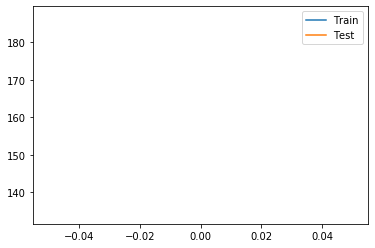

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

In [28]:
preds = model_fc.predict(features)

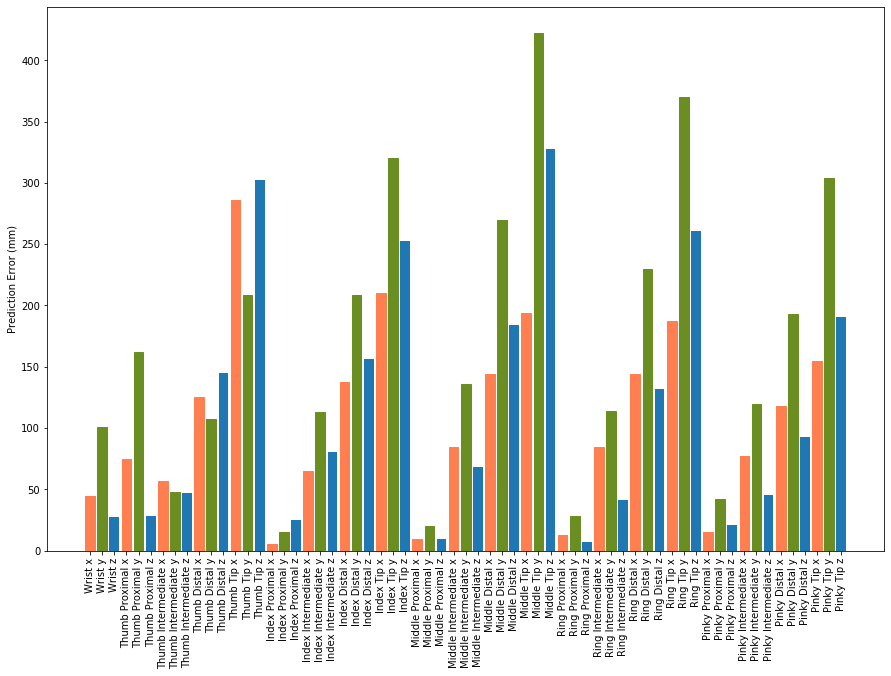

In [29]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

In [22]:
model_fc.save('FC_5seg_all_joints_model.h5')